# Comparing models

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
os.chdir('../models')

In [2]:
def get_results(names):
    s_list = []
    m_list = []
    for name in names:
        dist = np.load(name+'.npz')
        scores = np.asarray(dist['scores']).flatten()
        moves = np.asarray(dist['moves']).flatten()
        scores.sort()
        moves.sort()
        s_list.append(scores)
        m_list.append(moves)
    s_list = np.vstack(s_list)
    m_list = np.vstack(m_list)
    log_scores = np.log10(s_list + 1)

    print(s_list.shape)
    print(np.mean(log_scores, axis=1))
    return s_list, m_list, log_scores

In [3]:
def plot_results(s_list, log_scores, m_list, names):
    plt.figure(figsize=(15, 4))
    plt.subplot(141)
    for s in s_list:
        plt.plot(s)
    plt.legend(names, fontsize='small')
    plt.title('Scores')
    plt.subplot(142)
    for s in log_scores:
        plt.plot(s)
    plt.title('Scores Log 10')
    plt.subplot(143)
    for s in m_list:
        plt.plot(s)
    plt.title('Moves')
    plt.subplot(144)
    for s in m_list:
        plt.plot(s[:100])
    plt.title('Moves')
    plt.show()

In [4]:
def stats_test(a, b):
    print(stats.ks_2samp(a, b))
    print(stats.ttest_ind(a, b, equal_var=False))
    print('-'*10)

In [4]:
f = np.linspace(0, 1, 5000)
print('Sorted index for median of 1 sample:', np.argmax(1-(1-f)**1 >= 0.5))
print('Sorted index for median of min of 50:', np.argmax(1-(1-f)**50 >= 0.5))
print('Sorted index for median of min of 200:', np.argmax(1-(1-f)**200 >= 0.5))

Sorted index for median of 1 sample: 2500
Sorted index for median of min of 50: 69
Sorted index for median of min of 200: 18


## First 200 games

(3, 5000)
[3.35464984 3.80786514 3.56930305]


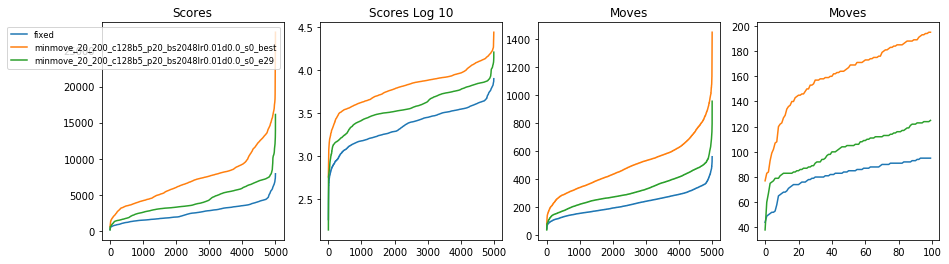

Early stopping vs final network: It does get worse as networ overtrains


In [16]:
names = ['fixed',
         '20200126/minmove_20_200_c128b5_p20_bs2048lr0.01d0.0_s0_best',
         '20200126/minmove_20_200_c128b5_p20_bs2048lr0.01d0.0_s0_e29']

s_list, m_list, log_scores = get_results(names)
names = ['fixed'] + [n[9:] for n in names[1:]]

plot_results(s_list, log_scores, m_list, names)

print('Early stopping vs final network: It does get worse as networ overtrains')

(3, 5000)
[3.35464984 3.80786514 3.74652316]


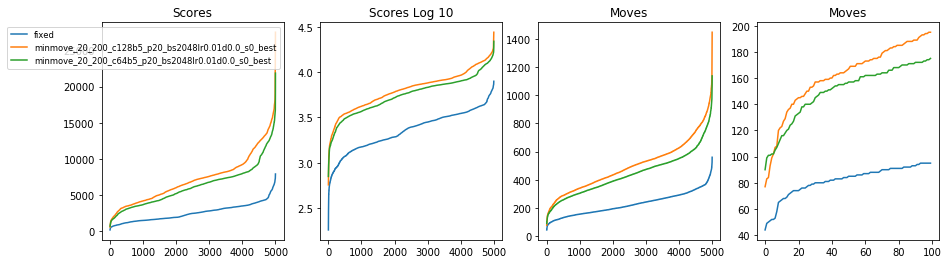

less channels is only slightly weaker


In [31]:
names = ['fixed',
         '20200126/minmove_20_200_c128b5_p20_bs2048lr0.01d0.0_s0_best',
         '20200126/minmove_20_200_c64b5_p20_bs2048lr0.01d0.0_s0_best']

s_list, m_list, log_scores = get_results(names)
names = ['fixed'] + [n[9:] for n in names[1:]]

plot_results(s_list, log_scores, m_list, names)

print('less channels is only slightly weaker')

(4, 5000)
[3.35464984 3.74652316 3.84505518 3.81622529]


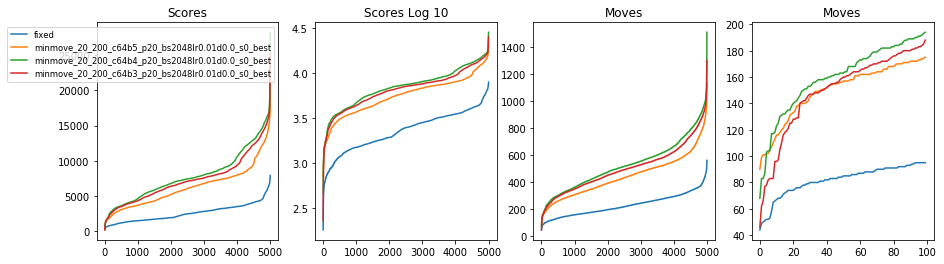

Less blocks is stronger, 64b4 ~ 128b5, 64b3 is very fast


In [34]:
names = ['fixed',
         '20200126/minmove_20_200_c64b5_p20_bs2048lr0.01d0.0_s0_best',
         '20200126/minmove_20_200_c64b4_p20_bs2048lr0.01d0.0_s0_best',
         '20200126/minmove_20_200_c64b3_p20_bs2048lr0.01d0.0_s0_best']

s_list, m_list, log_scores = get_results(names)
names = ['fixed'] + [n[9:] for n in names[1:]]

plot_results(s_list, log_scores, m_list, names)

print('Less blocks is stronger, 64b4 ~ 128b5, 64b3 is very fast')

(3, 5000)
[3.35464984 3.84505518 3.83942632]


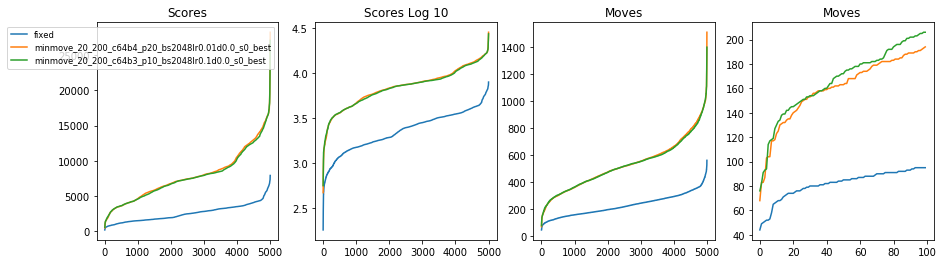

Ks_2sampResult(statistic=0.19999999999999996, pvalue=0.031376652153072594)
Ttest_indResult(statistic=-1.6024430795871405, pvalue=0.11065985075506886)
----------
Tuning training parameters gives slightly better b3 network


In [38]:
names = ['fixed',
         '20200126/minmove_20_200_c64b4_p20_bs2048lr0.01d0.0_s0_best',
         '20200126/minmove_20_200_c64b3_p10_bs2048lr0.1d0.0_s0_best']

s_list, m_list, log_scores = get_results(names)
names = ['fixed'] + [n[9:] for n in names[1:]]

plot_results(s_list, log_scores, m_list, names)

stats_test(m_list[1, :100], m_list[2, :100])

print('Tuning training parameters gives slightly better b3 network')

(4, 5000)
[3.35464984 3.83942632 3.83872295 3.77185286]


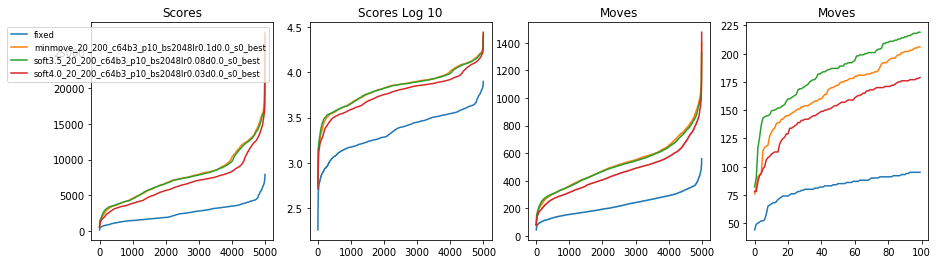

Tuning training parameters gives slightly better b3 network


In [40]:
names = ['fixed',
         '20200126/minmove_20_200_c64b3_p10_bs2048lr0.1d0.0_s0_best',
         '20200126/soft3.5_20_200_c64b3_p10_bs2048lr0.08d0.0_s0_best',
         '20200126/soft4.0_20_200_c64b3_p10_bs2048lr0.03d0.0_s0_best']

s_list, m_list, log_scores = get_results(names)
names = ['fixed'] + [n[9:] for n in names[1:]]

plot_results(s_list, log_scores, m_list, names)


print('Got lucky with a stronger network. It is reflected in 5000 eval.')

#### Picking the best seed
Final net is more than 2x stronger than Fixed as measured by min_move_dead

(2, 5000)
[3.83872295 3.87118302]


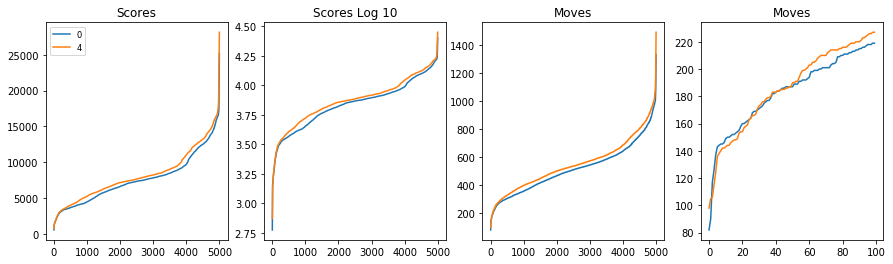

In [46]:
names = [f'20200126/soft3.5_20_200_c64b3_p10_bs2048lr0.08d0.0_s{s}_best'
         for s in (0, 4)]

s_list, m_list, log_scores = get_results(names)
names = [0, 4]

plot_results(s_list, log_scores, m_list, names)

# 400 games

(4, 5000)
[3.93753745 3.97354084 3.95182401 3.97699261]


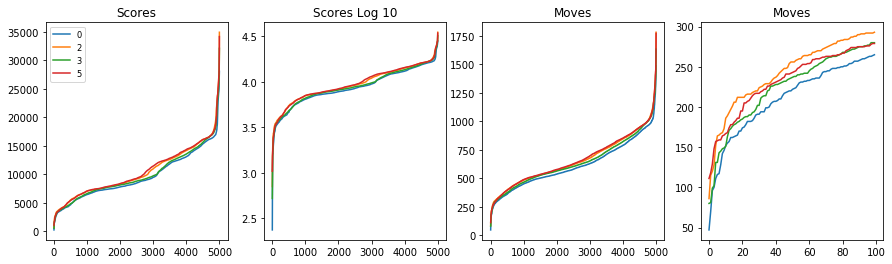

Seed 2 (best on 10x 50-game eval) is still best


In [8]:
names = [f'20200128/20_400_soft3.5c64b3_p10_bs2048lr0.08d0.0_s{s}pre_best' for s in (0,2,3,5)]

s_list, m_list, log_scores = get_results(names)
names = (0,2,3,5)

plot_results(s_list, log_scores, m_list, names)
print('Seed 2 (best on 10x 50-game eval) is still best')

(3, 5000)
[3.35464984 3.87118302 3.97354084]


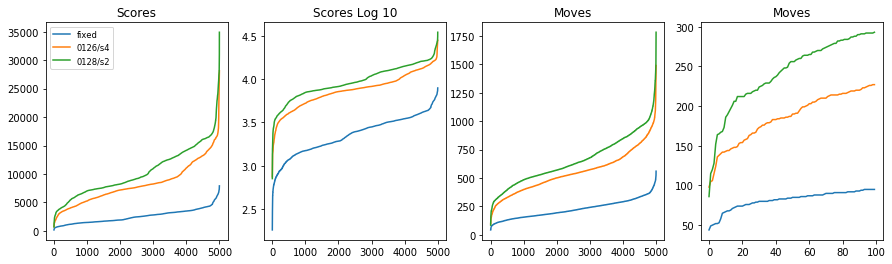

In [5]:
names = ['fixed',
         '20200126/soft3.5_20_200_c64b3_p10_bs2048lr0.08d0.0_s4_best',
         '20200128/20_400_soft3.5c64b3_p10_bs2048lr0.08d0.0_s2pre_best']

s_list, m_list, log_scores = get_results(names)
names = ['fixed','0126/s4', '0128/s2']

plot_results(s_list, log_scores, m_list, names)

# 600 games

(4, 5000)
[3.97354084 4.01132523 4.03133378 4.03316535]


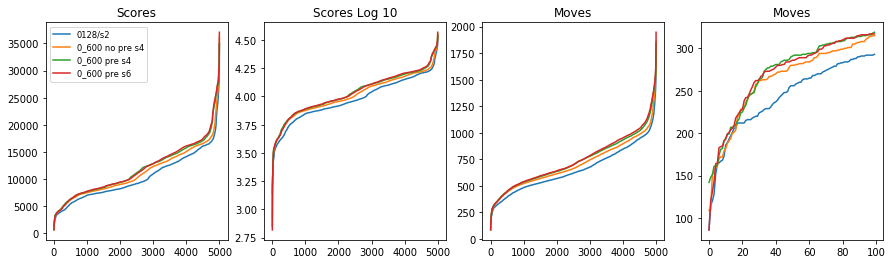

In [5]:
names = ['20200128/20_400_soft3.5c64b3_p10_bs2048lr0.08d0.0_s2pre_best',
         '20200130/0_600_soft3.5c64b3_p10_bs2048lr0.08d0.0_s4_best',
         '20200130/0_600_soft3.5c64b3_p10_bs2048lr0.08d0.0_s4pre_best',
         '20200130/0_600_soft3.5c64b3_p10_bs2048lr0.08d0.0_s6pre_best']

s_list, m_list, log_scores = get_results(names)
names = ['0128/s2','0_600 no pre s4', '0_600 pre s4', '0_600 pre s6']

plot_results(s_list, log_scores, m_list, names)

(4, 5000)
[4.03133378 4.02055569 4.03316535 4.0371024 ]


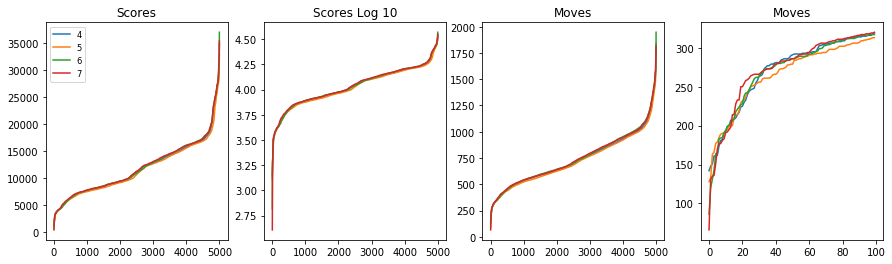

All pretty much equivalent


In [9]:
names = [f'20200130/0_600_soft3.5c64b3_p10_bs2048lr0.08d0.0_s{s}pre_best' for s in (4,5,6,7)]

s_list, m_list, log_scores = get_results(names)
names = (4,5,6,7)

plot_results(s_list, log_scores, m_list, names)
print('All pretty much equivalent')

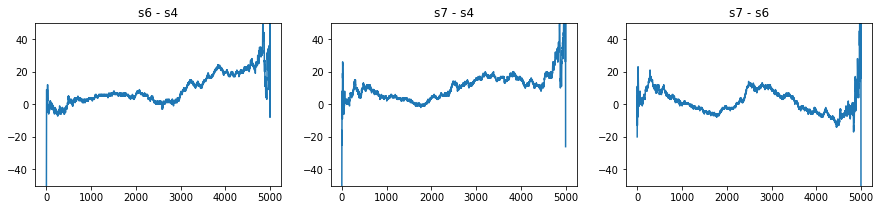

In [18]:
plt.figure(figsize=(15,3))
plt.subplot(131)
plt.plot(m_list[2] - m_list[0])
plt.title('s6 - s4')
plt.ylim([-50, 50])
plt.subplot(132)
plt.plot(m_list[3] - m_list[0])
plt.title('s7 - s4')
plt.ylim([-50, 50])
plt.subplot(133)
plt.plot(m_list[3] - m_list[2])
plt.title('s7 - s6')
plt.ylim([-50, 50])
plt.show()

Seed 7 has the highest mean (& therefore total) moves. Initial strength in the rogion 0-1000 strongest, although it has one very early death. Mid to late game is slightly weaker than seed 6, but the very endgame appears strong besides seed 6 having one really good game. I will go with seed 7.

(4, 5000)
[3.35464984 3.87118302 3.97354084 4.0371024 ]


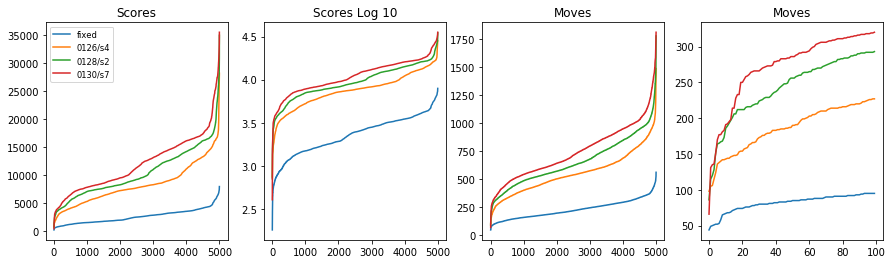

In [20]:
names = ['fixed',
         '20200126/soft3.5_20_200_c64b3_p10_bs2048lr0.08d0.0_s4_best',
         '20200128/20_400_soft3.5c64b3_p10_bs2048lr0.08d0.0_s2pre_best',
         '20200130/0_600_soft3.5c64b3_p10_bs2048lr0.08d0.0_s7pre_best'
        ]

s_list, m_list, log_scores = get_results(names)
names = ['fixed','0126/s4', '0128/s2', '0130/s7']

plot_results(s_list, log_scores, m_list, names)

Improvement seems to be slowing down, which is a worrying trend that I also saw last time doing min_move_dead.